# **Covid19 detection using chest X-ray images and Deep Learning**

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']=""


import tensorflow as tf
import keras

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,InceptionV3,ResNet50, MobileNetV2
from keras.applications.vgg16 import preprocess_input
#from keras.applications.mobilenetv2 import preprocess_input
#from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
from PIL import Image


Using TensorFlow backend.


# ***Import data ***

In [0]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()



In [6]:
!unzip /content/covid-chestxray-dataset-master.zip

Archive:  /content/covid-chestxray-dataset-master.zip
   creating: test_generator/
   creating: test_generator/COVID-19/
  inflating: test_generator/COVID-19/COVID-19-1.jpeg  
  inflating: test_generator/COVID-19/COVID-19-100.jpeg  
  inflating: test_generator/COVID-19/COVID-19-101.jpeg  
  inflating: test_generator/COVID-19/COVID-19-102.jpeg  
  inflating: test_generator/COVID-19/COVID-19-103.jpeg  
  inflating: test_generator/COVID-19/COVID-19-104.jpeg  
  inflating: test_generator/COVID-19/COVID-19-105.jpeg  
  inflating: test_generator/COVID-19/COVID-19-106.jpeg  
  inflating: test_generator/COVID-19/COVID-19-107.jpeg  
  inflating: test_generator/COVID-19/COVID-19-108.jpeg  
  inflating: test_generator/COVID-19/COVID-19-109.jpg  
  inflating: test_generator/COVID-19/COVID-19-110.jpg  
  inflating: test_generator/COVID-19/COVID-19-111.jpg  
  inflating: test_generator/COVID-19/COVID-19-112.jpg  
  inflating: test_generator/COVID-19/COVID-19-113.jpg  
  inflating: test_generator/COV

# ***DATASET ***

In [0]:
train_path = "/content/train_generator/train"
test_path = "/content/train_generator/test"

# **Creating Train and Test Data Generators ** ****

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
 rotation_range=20,
 featurewise_center = True,
 featurewise_std_normalization = True,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.25,
 zoom_range=0.1,
 zca_whitening = True,
 channel_shift_range = 20,
 horizontal_flip = True ,
 vertical_flip = True ,
 validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size = (224, 224),
    shuffle=True,seed=42,class_mode="categorical", color_mode = 'rgb', batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 156 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


# **Using Transfer learning and downloading the weights of VGG16**

In [15]:
basemodel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 2s 0us/step


# **Caracteristic model**

In [0]:
headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)#pool_size=(4, 4)
headModel = Flatten(name="flatten")(headModel)
#headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
#headModel = Dense(256, activation="relu")(headModel)
#headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=basemodel.input, outputs=headModel)

for layer in basemodel.layers:
    layer.trainable = False
    
epochs= 100
lr = 1e-4
BS = 16

# **Compilation**

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4,decay=lr/epochs),metrics=["accuracy"])

#history = model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=BS),steps_per_epoch=len(X_train) // BS,validation_data=(X_test, Y_test),validation_steps=len(X_test) // BS,epochs=epochs)
model.fit_generator(train_generator,
                    steps_per_epoch = 270//BS,
                    epochs = epochs,
                    validation_data = test_generator,
                    validation_steps = 36//BS)


Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
16/16 [==============================] - 77s 5s/step - loss: 0.6052 - accuracy: 0.7183 - val_loss: 0.2718 - val_accuracy: 1.0000
Epoch 2/100
16/16 [==============================] - 74s 5s/step - loss: 0.5348 - accuracy: 0.7823 - val_loss: 0.1675 - val_accuracy: 1.0000
Epoch 3/100
16/16 [==============================] - 77s 5s/step - loss: 0.4200 - accuracy: 0.8571 - val_loss: 0.1546 - val_accuracy: 1.0000
Epoch 4/100
16/16 [==============================] - 75s 5s/step - loss: 0.4595 - accuracy: 0.8306 - val_loss: 0.1493 - val_accuracy: 1.0000
Epoch 5/100
16/16 [==============================] - 79s 5s/step - loss: 0.4582 - accuracy: 0.8508 - val_loss: 0.1521 - val_accuracy: 1.0000
Epoch 6/100
16/16 [==============================] - 77s 5s/step - loss: 0.4294 - accuracy: 0.8452 - val_loss: 0.1982 - val_accuracy: 1.0000
Epoch 7/100
16/16 [==============================] - 77s 5s/step - loss: 0.4377 - accuracy: 0.8387 - val_loss: 2.0637 - val_accuracy: 0.0000e+00
Epoch 8/1

# Evaluation 

In [18]:
#x = model.evaluate_generator(test_generator, steps = np.ceil(len(test_generator) // BS),
x = model.evaluate_generator(test_generator, steps = np.ceil(len(test_generator)),
 use_multiprocessing = False,
 verbose = 1,
 workers=1
 )


Instructions for updating:
Please use Model.evaluate, which supports generators.
24/24 [==============================] - 8s 329ms/step - loss: 0.5273 - accuracy: 0.7083


# **Prediction**

Instructions for updating:
Please use Model.predict, which supports generators.
1000/1000 [==============================] - 343s 343ms/step
Predictions finished
prob:[0.84158677 0.15841325]
COVID-19/COVID-19-140.png


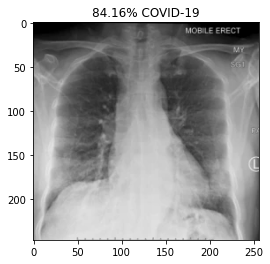

prob:[0.7681656  0.23183435]
COVID-19/COVID-19-141.png


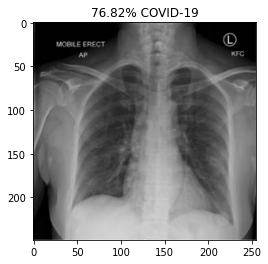

prob:[0.69874245 0.30125752]
COVID-19/COVID-19-142.jpeg


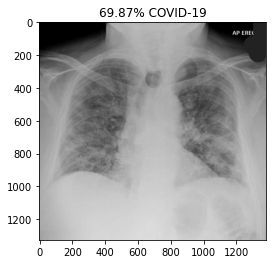

prob:[0.71270245 0.28729752]
COVID-19/COVID-19-143.jpg


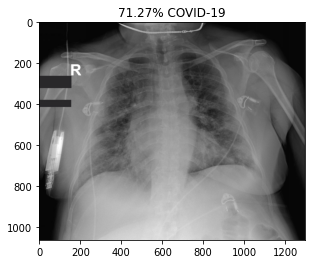

prob:[0.7327747 0.2672253]
COVID-19/COVID-19-144.jpg


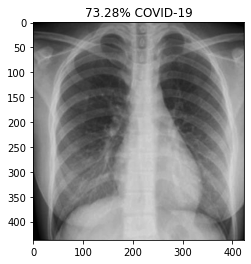

prob:[0.9334339  0.06656615]
COVID-19/COVID-19-145.jpeg


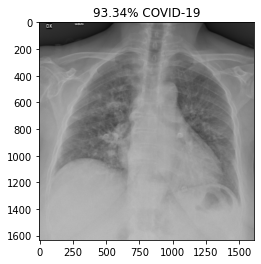

prob:[0.6996127  0.30038735]
COVID-19/COVID-19-146.jpeg


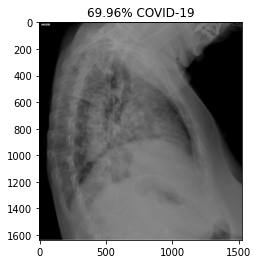

prob:[0.6923963  0.30760375]
COVID-19/COVID-19-147.jpeg


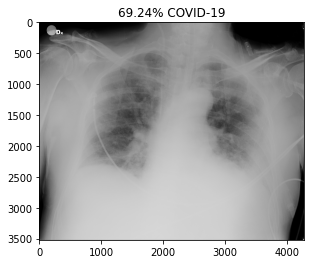

prob:[0.681252 0.318748]
COVID-19/COVID-19-148.jpeg


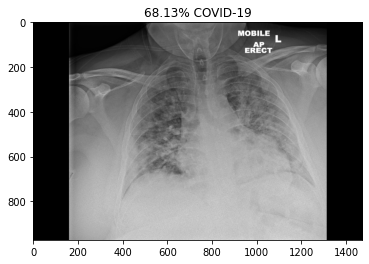

prob:[0.60898924 0.3910108 ]
COVID-19/COVID-19-149.jpeg


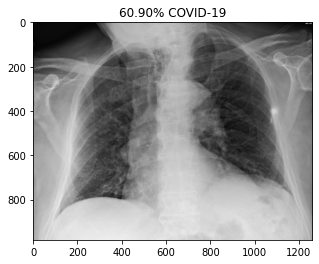

prob:[0.66889006 0.33110988]
COVID-19/COVID-19-150.jpeg


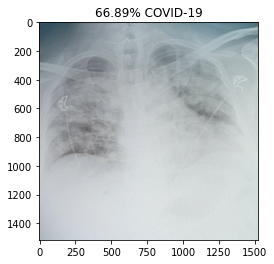

prob:[0.9234214  0.07657859]
COVID-19/COVID-19-151.jpeg


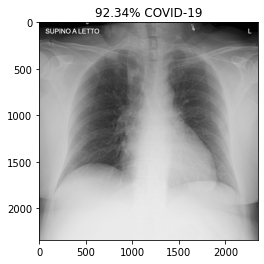

prob:[0.95564526 0.04435476]
COVID-19/COVID-19-152.jpeg


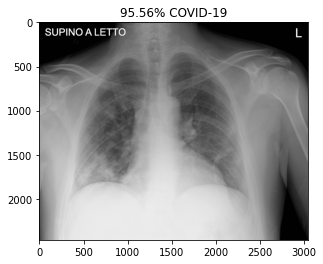

prob:[0.876986   0.12301399]
COVID-19/COVID-19-153.jpeg


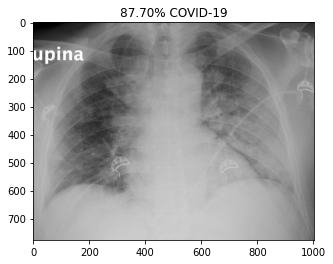

prob:[0.96343416 0.03656578]
COVID-19/COVID-19-154.jpeg


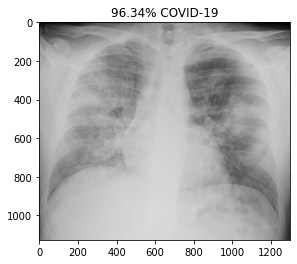

prob:[0.7701923  0.22980775]
COVID-19/COVID-19-155.jpeg


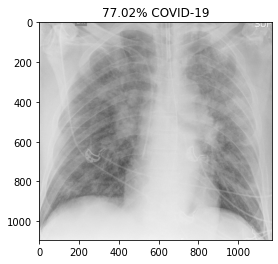

prob:[0.8883418  0.11165816]
COVID-19/COVID-19-156.jpeg


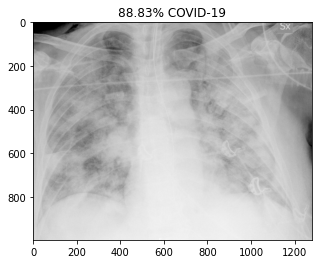

prob:[0.80550665 0.19449341]
other/SARS-20.jpeg


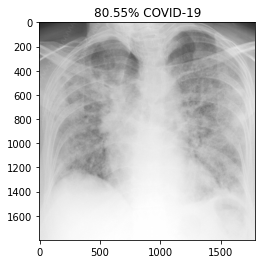

prob:[0.77375674 0.22624323]
other/Streptococcus-62.jpg


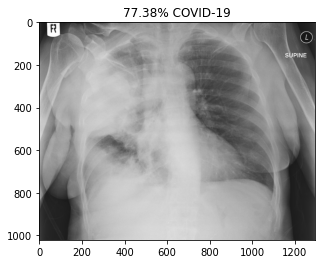

prob:[0.962514   0.03748603]
other/Streptococcus-63.jpg


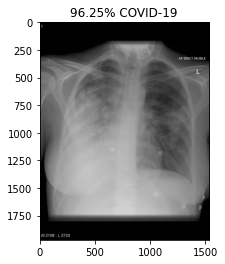

prob:[0.83027864 0.16972134]
other/Streptococcus-64.jpg


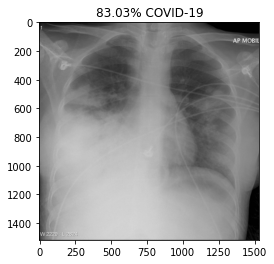

prob:[0.7850443  0.21495572]
other/Streptococcus-65.jpg


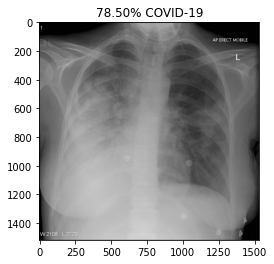

prob:[0.8628509  0.13714907]
other/Streptococcus-66.jpg


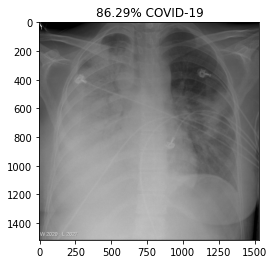

prob:[0.8497846  0.15021537]
other/Streptococcus-67.jpg


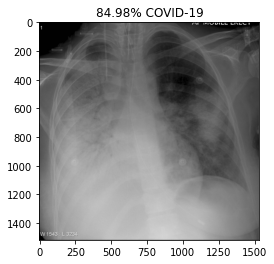

IndexError: ignored

In [19]:
pred = model.predict_generator(test_generator,1000,verbose=1)
print("Predictions finished")
import cv2
import matplotlib.image as mpimg
for index, probability in enumerate(pred):
 image_path = test_path + "/" +test_generator.filenames[index]
 image = mpimg.imread(image_path)
 #BGR TO RGB conversion using CV2
 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 pixels = np.array(image)
 plt.imshow(pixels)
 print("prob:{}".format(probability))
 print(test_generator.filenames[index])
 if probability[1] > 0.5:
     plt.title('%.2f' % (probability[1]*100) + '% Other')
 else:
     plt.title('%.2f' % ((1-probability[1])*100) + '% COVID-19')
 plt.show()

# ***Test par image ***

[[1.0, 1.8584264079852543e-26]]

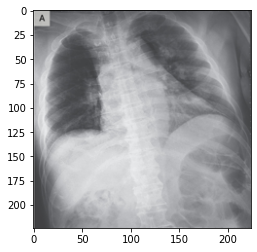

In [21]:
image_test = Image.open("/content/test_generator/COVID-19/COVID-19-1.jpeg").convert('RGB')
image_test = image_test.resize((224,224))
data_test = np.asarray(image_test)
img = np.reshape(data_test,[1,224,224,3])

plt.imshow(image_test)
model.predict(img).tolist()